In [1]:
%matplotlib widget
from bmcs_cross_section.api import MKappa, EC2, ACI318,  ReinfLayer, EC2ConcreteMatMod, EC2PlateauConcreteMatMod, ACI440, AnaFRPBending
from bmcs_beam.api import FourPBSystem, BoundaryConditions, BoundaryConfig, DeflectionProfile, BeamDesign, BeamSLSCurve
import numpy as np
import pandas as pd
import bmcs_utils.api as bu
import matplotlib.pyplot as plt

# Functions definition

## Model objects functions:

In [2]:
# F_crack in kN read visually from curves
F_crack = [7.32, 6.48, 6.74, 5.89, 2.9, 2.2, 2.95, 6.73, 7.27, 6.94, 6.27, 6.3, 5.9]

In [3]:
# Concrete C3-HF2-165-4
E_cm_C3 = 44049.8
f_cm_C3 = 96.96
fctm_sp = 4.89
fctm_fl = 11.62

In [4]:
# solidian GRID Q95-CCE-38-E5 (according to performed tensile tests)
f_t_mat = 3823.9
E_f_mat = 246525.28

In [52]:
def get_dp(f_cm = f_cm_C3, E_cm = E_cm_C3, fctm_fl=None,
           setup='4pb', L=1800, L_F=None,
           high_kappa = 0.00018, concrete_law='EC2',
           B=200, H=150, A = None,
           reinf = 'carbon',
           E_nm=None, f_t=None, z=None,
           grid_layers_spacing=[], grid_layers_area=[],
          design_mode = False,
          ):
    
    mc = MKappa(low_kappa = 0, high_kappa = high_kappa, n_kappa=400)
    
    mc.cs_design.matrix=concrete_law
    
    f_ck = EC2.get_f_ck_from_f_cm(f_cm)
    if fctm_fl is None:
        fctm_fl = EC2.get_f_ctm_fl(f_ck, H)
    if concrete_law == 'EC2 with plateau' or concrete_law == 'EC2':
        mc.cs_design.matrix_.trait_set(f_cm = f_cm)
    elif concrete_law == 'piecewise linear':
        mc.cs_design.matrix_.trait_set(
            eps_cy=EC2.get_eps_c3(f_ck),
            eps_cu=EC2.get_eps_cu3(f_ck),
        )
    
    mc.cs_design.matrix_.trait_set(E_cc=None if design_mode else E_cm, 
                                   E_ct=None if design_mode else E_cm, 
                                   eps_cr = fctm_fl/E_cm, 
                                   eps_tu = fctm_fl/E_cm,
                                   factor = 0.85 / 1.5 if design_mode else 1,
                                  )

    mc.cross_section_shape_.B = B
    mc.cross_section_shape_.H = H

    # Carbon properties
    E_nm=E_f_mat if E_nm is None else E_nm
    f_t=f_t_mat if f_t is None else f_t
    spacing = 38
    rov_num = int(B/spacing) + 1
    rov_cs_area = 3.62
    if A is None:
        A = rov_num * rov_cs_area
    if z is None:
        z = 10
        
    d = H - z
    
    grid_layers_n = len(grid_layers_area) if grid_layers_area else 1
    if reinf == 'carbon':
        if grid_layers_n == 1:
            bl1 = ReinfLayer(name='grid', z=z, A=A, matmod='carbon')
            bl1.matmod_.trait_set(E=E_nm, f_t=f_t, factor = (0.85 * 0.9 / 1.3) * (0.85) if design_mode else 1)
            mc.cross_section_layout.add_layer(bl1)
        else:
            for i in range(grid_layers_n):
                bl1 = ReinfLayer(name='grid ' + str(i+1), 
                                 z=grid_layers_spacing[i] if grid_layers_spacing else 10, 
                                 A=grid_layers_area[i] if grid_layers_area else A, 
                                 matmod='carbon')
                bl1.matmod_.trait_set(E=E_nm, f_t=f_t, factor = (0.85 * 0.9 / 1.3) * (0.85) if design_mode else 1)
                mc.cross_section_layout.add_layer(bl1)
            A = grid_layers_n * A
    else:
        bl1 = ReinfLayer(name='rebars', z=z, A=A, matmod='steel')
        bl1.matmod_.factor = 1 / 1.15 if design_mode else 1
        mc.cross_section_layout.add_layer(bl1)

    rho = A/(B*d)
    print('A=', A)
    print(r'rho =', round(rho * 100, 2), r'%')
    # mechanical reinforcement ratio
#     w_m = A * f_t / (B * H * f_cm)
#     print('w_m:', w_m)

    dp = DeflectionProfile(mc=mc)
    
    if setup == '4pb':
        dp.beam_design.system = '4pb'
        if L_F is not None:
            print('L_F assigned!')
            dp.beam_design.system_.L_F = L_F
    elif setup == '3pb':
        dp.beam_design.system = '3pb'
    elif setup == 'dist':
        dp.beam_design.system = 'simple_beam_dist_load'
        
    dp.beam_design.system_.L = L
    
    print('l/d =', dp.beam_design.system_.L/d)
    
    return dp

def get_exp_fw_avg(test_num=1, ax=None):
    similar_test_list = [[1, 2], [3, 4], [5, 6, 7], [8, 9], [10, 11], [12, 13]]
    for lis in similar_test_list:
        if test_num in lis:
            f, w = bu.get_fw_curves_avg([get_exp_fw(test_num_, as_one_array=True) for test_num_ in lis], ax=ax)
            if ax is not None:
                ax.plot(w, f, label=r'exp_fw_avg')
            return f, w

def get_exp_fw_avg_asc(test_num=1, ax=None):
    exp_fw_avg = get_exp_fw_avg(test_num)
    f_avg_desc, w_avg_desc = bu.get_exp_fw_asc(exp_fw_avg)
    if ax is not None:
        ax.plot(w_avg_desc, f_avg_desc, 'g', label=r'exp_fw_avg_asc')
    return w_avg_desc, f_avg_desc

def get_exp_fw_asc(test_num=1, ax=None):
    f_asc, w_asc = bu.get_exp_fw_asc(get_exp_fw(test_num))
    if ax is not None:
        ax.plot(w_asc, f_asc, 'g', label=r'exp_fw_asc')
    return w_asc, f_asc

def get_limit_values(dp, test_num=1, df = None):
    f_cm = dp.mc.cs_design.matrix_.f_cm
    E_cm = dp.mc.cs_design.matrix_.E_cc
    f_ctm = dp.mc.cs_design.matrix_.f_ctm
    b = dp.mc.cross_section_shape_.B
    h = dp.mc.cross_section_shape_.H
    L = dp.beam_design.L / 1000
    w_sls = L * 1000/250 # ACI uses 240 for l/d studies (see ACI 440 PDF p. 24), but no big difference so 250 used
    
    f_crack_exp = np.array(F_crack)
    f_crack_exp = f_crack_exp[test_num - 1]
    M_crack_exp = f_crack_exp * L / 4 if test_num == 8 or test_num == 9 else f_crack_exp * L / 6
    
    f_exp, w_exp = get_exp_fw(test_num)
    f_max_exp = np.nanmax(f_exp)
    M_max_exp = f_max_exp * L / 4 if test_num == 8 or test_num == 9 else f_max_exp * L / 6
    w_max_exp = np.nanmax(w_exp)
    
    f_sim, w_sim = dp.get_Fw()
    f_sim = dp.final_plot_F_scale * f_sim
    f_max_sim = np.max(f_sim)
    w_max_sim = np.max(w_sim)

    f_exp_asc, w_exp_asc = bu.get_exp_fw_asc([f_exp, w_exp])
    f_sls_exp = np.interp(w_sls, w_exp_asc, f_exp_asc)
    M_sls_exp = f_sls_exp  * L / 4 if test_num == 8 or test_num == 9 else f_sls_exp * L / 6
    f_sls_to_max = f_sls_exp / f_max_exp
    
    w_sls_sim = np.interp(f_sls_exp, f_sim, w_sim)
    
    A_f_list = []
    z_list = []
    E_carbon = E_f_mat
    f_t_carbon = f_t_mat
    E_steel = 200000
    f_sy = 500
    
    for reinf_layer in list(dp.mc.cross_section_layout.items.values()):
        A_f_list.append(reinf_layer.A)
        z_list.append(reinf_layer.z)
        
    A_f_list = np.array(A_f_list)
    z_list = np.array(z_list)
    A_f_tot = np.sum(A_f_list)
    d_eqv = np.full_like(z_list, h) - z_list
    d_eqv = np.sum(d_eqv * A_f_list) / A_f_tot
    
    if test_num in [10, 11]: # hybrid
        M_aci = np.nan
    elif test_num in [12, 13]:
        M_aci = ACI318.get_M_n(A_s=A_f_tot, f_y=f_sy, f_c=f_cm, b=b, d=d_eqv)
    else:
        M_aci = ACI440.get_M_n(A_f=A_f_tot, f_fu=f_t_carbon, E_f=E_carbon, f_c=f_cm, b=b, d=d_eqv)
        
    f_max_aci = 4 * M_aci / L if test_num in [8, 9] else 6 * M_aci / L
    
    if test_num in [10, 11]:
        w_sls_aci = np.nan
        M_crack_aci = np.nan
    elif test_num in [12, 13]:
        w_sls_aci, (_, _, _, M_crack_aci) = ACI318.get_w(A_s=A_f_tot, 
                                 E_c = E_cm, 
                                 f_ct = f_ctm, 
                                 E_s = 200000, 
                                 M_a = M_sls_exp*1e6, 
                                 f_c=f_cm, h=h, b=b, 
                                 d=d_eqv, l=L*1000, l_a=L*1000/3, 
                                 load_type='3pb' if test_num == 8 or test_num == 9 else '4pb')
        M_crack_aci = M_crack_aci/1e6
    else:
        w_sls_aci, (_, _, _, M_crack_aci) = ACI440.get_w(A_f=A_f_tot, 
                                 E_c = E_cm, 
                                 f_ct = f_ctm, 
                                 E_f = E_carbon, 
                                 M_a = M_sls_exp*1e6, 
                                 f_c=f_cm, h=h, b=b, 
                                 d=d_eqv, l=L*1000, l_a=L*1000/3, 
                                 load_type='3pb' if test_num == 8 or test_num == 9 else '4pb')
        M_crack_aci = M_crack_aci/1e6
    
    if df is None:
        namings = ['f_max_exp', 'f_max_sim', 'f_max_aci', 'w_max_exp', 
                   'w_max_sim', 'f_sls_exp', 'f_sls_to_max', 'M_crack_exp', 'M_crack_aci', 
                   'w_sls', 'w_sls_sim', 'w_sls_aci']
        units = ['[kN]', '[kN]', '[kN]', '[mm]', 
                   '[mm]', '[kN]', '[-]', '[kNm]', '[kNm]', 
                   '[mm]', '[mm]', '[mm]']
        df = pd.DataFrame(columns=pd.MultiIndex.from_arrays([namings, units]))

    new_row_idx = len(df)
    df.loc[new_row_idx] = [f_max_exp, f_max_sim, f_max_aci, w_max_exp,
                          w_max_sim, f_sls_exp, f_sls_to_max, M_crack_exp, M_crack_aci,
                          w_sls, w_sls_sim, w_sls_aci]
    
    decimal_places = {'f_max_exp': 2, 'f_max_sim': 2, 'f_max_aci': 2, 'w_max_exp': 1,
                      'w_max_sim': 1, 'f_sls_exp': 2, 'f_sls_to_max': 2, 'M_crack_exp': 1, 'M_crack_aci': 1,
                      'w_sls': 1, 'w_sls_sim': 1, 'w_sls_aci': 1}
    for column, decimals in decimal_places.items():
        df[column] = df[column].round(decimals)
        
    return df

## Importing data functions:

In [73]:
def get_exp_data_gom(test_num=1):
    file_path = './results/T' + str(test_num) + '_GOM.csv'
    df = pd.read_csv(file_path, delimiter=';', decimal=',', skiprows = [1])
    
    force = -np.array(df['Kraft'])
    top_strain = np.array(df['top_strain_right']) if 'top_strain_right' in df else None
    bottom_strain = np.array(df['bottom_strain_right']) if 'bottom_strain_right' in df else None
    if top_strain is None or bottom_strain is None:
        top_strain = np.array(df['top_strain_left']) if 'top_strain_left' in df else None
        bottom_strain = np.array(df['bottom_strain_left']) if 'bottom_strain_left' in df else None
    disp_right = -np.array(df['Deflection_dic_right']) if 'Deflection_dic_right' in df else None
    disp_left = -np.array(df['Deflection_dic_left']) if 'Deflection_dic_left' in df else None
    disp_avg = (disp_left + disp_right)/2
  
    return force, disp_avg, top_strain, bottom_strain

def get_exp_data(test_num=1):
    skiprows = 3
    delimiter=';'
    decimal=','
    file_path = './results/T' + str(test_num) + '.csv'
    headers_array = list(np.array(pd.read_csv(file_path, delimiter=delimiter, decimal=decimal, nrows=1, header=None))[0])
    
    time_idx = 0
    force_idx = headers_array.index('Kraft')
    weg_idx = headers_array.index('Weg')
    IWA_M_hinten_idx = headers_array.index('IWA_M_hinten')
    IWA_M_vorne_idx = headers_array.index('IWA_M_vorne')
    IWA_M_idx = headers_array.index('IWA_M')
    DMS_idx = headers_array.index('DMS-1')
    
    data = np.array(pd.read_csv(file_path, delimiter=delimiter, decimal=decimal, skiprows=skiprows))
    time = data[:, 0]
    force = -data[:, force_idx]
    dms = data[:, DMS_idx]
    midspan_hor = -data[:, IWA_M_idx]
    weg = -data[:, weg_idx]
    hinten_vorne = - data[:, (IWA_M_hinten_idx, IWA_M_vorne_idx)]
    avg_hinten_vorne = (hinten_vorne[:, 0] + hinten_vorne[:, 1])/2
    
    return time, force, weg, avg_hinten_vorne, dms, hinten_vorne, midspan_hor

def get_exp_fw(test_num=1, as_one_array=False):
    _, force, _, avg_hinten_vorne, _, hinten_vorne, _ = get_exp_data(test_num = test_num)
    if test_num == 7:
        avg_hinten_vorne = hinten_vorne[:, 0]
    elif test_num == 8:
        avg_hinten_vorne = hinten_vorne[:, 1]
    if as_one_array:
        fw = np.zeros((len(force), 2))
        fw[:, 0] = force
        fw[:, 1] = avg_hinten_vorne
        return fw
    else:
        return force, avg_hinten_vorne

## Plotting functions:

In [149]:
bu.set_latex_mpl_format()
plot_colors = bu.plot_colors

def plot_fw_gom(test_num=None, test_name='', dp=None, title=None, ax=None, limit_x_axis = False, color_i=0, plot_sls_limit=True):
    fig, ax = plot_fw(test_num=test_num, test_name=test_name, 
                          dp=None, title=title, ax=ax, color_i=color_i, 
                          plot_sls_limit=False, limit_x_axis=limit_x_axis)
    force, disp_avg, _, _ = get_exp_data_gom(test_num)
    ax.plot(disp_avg, force, c=plot_colors[color_i + 1], label = test_name + '_DIC')
    ax.legend()
    ax.set_title('LVDTs vs DIC comparison')
    return fig, ax

def plot_fw(test_num=None, test_name='', dp=None, title=None, ax=None, limit_x_axis = True, color_i=0, plot_sls_limit=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4.7))
    if dp:
        dp.plot_fw(ax, dashed=True, color=plot_colors[color_i], label=  test_name + ' (Sim.)', lw=1.5)
        if plot_sls_limit:
            sls_w_limit = dp.beam_design.system_.L/250
            ax.axvline(x=sls_w_limit)

    if test_num:
        f, w = get_exp_fw(test_num)
        ax.plot(w, f, c=plot_colors[color_i], label=  test_name + ' (Exp.)', lw=1.25)
        
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Midspan deflection [mm]')
    ax.set_ylabel('Load [kN]')
    if test_num not in [12, 13] and limit_x_axis:
        ax.set_xlim([-5, 105])
    ax.set_ylim([-3, 45])
    ax.legend()
#     ax.grid()
    return ax.get_figure(), ax
    
def plot_mk(test_num, dp, l_lvdt=200, gom=False, ax=None, color_1='#bc2122', color_2='black'):
    if gom:
        force, _, strain_midspan_top, strain_midspan_bottom = get_exp_data_gom(test_num)
    else:
        # I used l_lvdt = 200 mm as the LVDT distance, but this was not accurate and slightly different each test
        _, force, _, _, dms, _, midspan_hor = get_exp_data(test_num)
        strain_midspan_top = dms * 1e-6
        strain_midspan_bottom = midspan_hor / l_lvdt
    
    # Curvature
    h = 80 - 15 if test_num in [5, 6, 7] else 100 - 15
    kappa = -(strain_midspan_top - strain_midspan_bottom) / h
    
    # Moment
    L_F = 600 # distance to force
    L = 1800
    moment = (force * L / 4) / 1000 if test_num in [8, 9] else (force * L_F / 2) / 1000
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4.7))
    else:
        fig = ax.get_figure()
    if test_num not in [12, 13]:
        ax.set_xlim([-0.000015, 0.0003])
        
    ax.set_ylim([-0.5, 13.2])

    dp.mc.plot_mk(ax, color=color_2, dashed=True)
    ax.plot(kappa, moment, color=color_1, label='T' + str(test_num))
    ax.legend()
    fig.show()
    
    # max
    max_force_idx = np.argmax(force)
    max_comp_strain= strain_midspan_top[max_force_idx]
    max_tensile_strain = strain_midspan_bottom[max_force_idx]
    print('max_comp_strain =', max_comp_strain, ', max_tensile_strain = ', max_tensile_strain)

In [8]:
# M1 concrete mix (average of M1 + M2 in the excel table)
M1_f_cm = 98.63
M1_E_cm = 45306.54
M1_f_ctm = 5.11
M1_concrete = dict(f_cm= M1_f_cm, E_cm = M1_E_cm, fctm_fl=M1_f_ctm)

# M2 concrete mix (average of M3 + M4 in the excel table)
M2_f_cm = 95.3
M2_E_cm = 42793.1
M2_f_ctm = 4.67
M2_concrete = dict(f_cm= M2_f_cm, E_cm = M2_E_cm, fctm_fl=M2_f_ctm)

# Experiments

## T1_4PB_C_1, T2_4PB_C_1

In [9]:
# Using T1 exact dimensions
dp1_2 = get_dp(high_kappa =0.0003, B=303, H=99, setup='4pb', reinf = 'carbon', **M1_concrete)
dp1_2.interact()

A= 28.96
rho = 0.11 %
l/d = 20.224719101123597
V_Rm_c = 20.21 kN, Shear failure by F_tot_max = 40.42 kN


In [10]:
# Get load-deflection curve based on ACI deflection formulas
ws = []
fs = np.linspace(0, 30000, 200)
for f in fs:
    w, _ = ACI440.get_w(A_f=28.96, 
                     E_c = M1_E_cm, 
                     f_ct = M1_f_ctm, 
                     E_f=246525.28, 
                     M_a = (f/2)*600, 
                     f_c=98.63, h=99, b=303, 
                      d=89, l=1800, l_a=600, 
                     load_type='4pb')
    ws.append(w)

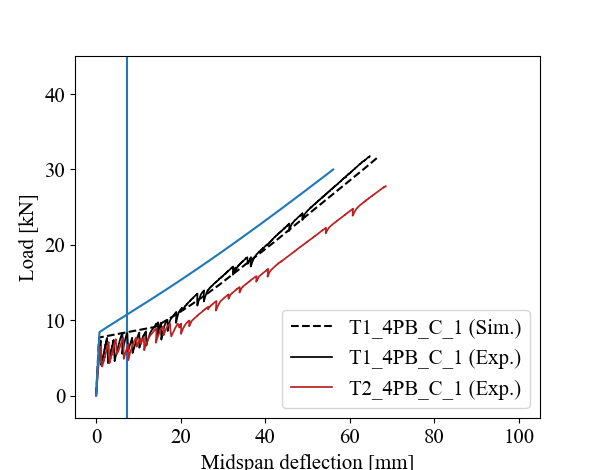

In [11]:
fig, ax = plot_fw(1, r'T1_4PB_C_1', dp=dp1_2, color_i=0)
plot_fw(2, r'T2_4PB_C_1', ax=ax, color_i=1)
# fig.savefig('T1_T2_ld_exp_vs_sim.pdf')
ax.plot(ws, fs/1000)
fig.show()

In [12]:
get_exp_fw_asc(1, ax=ax)

(array([-3.22437250e-03, -6.75201500e-04,  2.05040000e-04, ...,
         6.46951433e+01,  6.47153434e+01,  6.47299184e+01]),
 array([ 0.2974818,  0.3042434,  0.3057397, ..., 31.73034  , 31.73232  ,
        31.74916  ]))

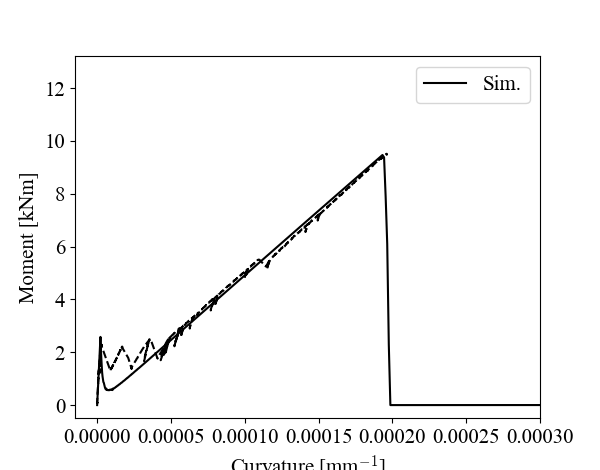

max_comp_strain = -0.0013027409999999998 , max_tensile_strain =  0.015386426666666668


In [112]:
plot_mk(1, dp1_2, l_lvdt=225)

### Other functions...

In [14]:
# dp1_2_d = get_dp(high_kappa =0.0003, B=303, H=99, setup='4pb', reinf = 'carbon', design_mode=True, **M1_concrete)
# dp1_2_d.interact()

In [15]:
# ACI440.get_M_n(A_f=28.96, f_fu=3823.9, E_f=246525.28, f_c=98.63, b=303, d=89)
# ACI440.get_rho_balanced(f_c=98.63, f_fu=3823.9, E_f=246525.28)

In [16]:
# fig4, axes = dp1_2.mc.plot_M_rho_and_util_factors(type='stress', n_rho = 50)
# fig4

In [17]:
# frp_b = AnaFRPBending(mc = dp1_2.mc)

# rho_f_list = np.linspace(0, 0.025, 300)
# psi_f_list = np.zeros_like(rho_f_list)
# psi_c_list = np.zeros_like(rho_f_list)
# M_u_list = np.zeros_like(rho_f_list)
# M_u_aci_list = np.zeros_like(rho_f_list)
# # f_cms = np.linspace(20, 108, 10)
# # rho_diff = np.zeros_like(f_cms)

# # fig3, (ax1, ax2, ax3) = plt.subplots(3, 1)

# for i, rho_f in enumerate(rho_f_list):
#     frp_b.A_f = rho_f * frp_b.b * frp_b.d
#     psi_f_list[i] = frp_b.psi_f
#     psi_c_list[i] = frp_b.psi_c
#     M_u_list[i] = frp_b.M_u
#     M_u_aci_list[i] = ACI440.get_M_n(A_f=rho_f * frp_b.b * frp_b.d, f_fu=3823.9, E_f=246525.28, f_c=98.63, b=303, d=89)

# ax1.plot(rho_f_list, M_u_list)
# ax1.plot(rho_f_list, M_u_aci_list)
# ax2.plot(rho_f_list, psi_f_list)
# ax2.plot(rho_f_list, psi_c_list)
# ax2.axvline(frp_b.rho_f_cy , ls='--', lw=1, c='black')
# ax2.axvline(frp_b.rho_fb , ls='--', lw=1, c='black')
# ax2.text(frp_b.rho_f_cy, 0, r'$\rho_{f, cy}$', rotation=90)
# ax2.text(frp_b.rho_fb, 0, r'$\rho_{fb}$', rotation=90)
# # fig3.show()
# # ax3.plot(f_cms, rho_diff)
# fig4.show()

In [18]:
# b_sls = BeamSLSCurve(f_ck = 90.63, rein_type = 'carbon_grid', system_type = '4pb', n_i=9, dense_quarter=True)
# # b_sls = BeamSLSCurve(dp = dp1_2)
# b_sls.interact()

In [19]:
# fig, axes = dp1_2.mc.plot_M_rho_and_util_factors(type='stress', n_rho = 30)
# # fig.savefig('hybrid_psi_ratios_factors_0.2_0.8.pdf')
# axes[0].axvline(x=0.11/100)
# axes[1].axvline(x=0.11/100)
# fig.show()

## T3_4PB_C_1.5, T4_4PB_C_1.5

In [20]:
# Using T3 exact dimensions
dp3_4 = get_dp(high_kappa =0.00025, B=303, H=98, setup='4pb', 
            reinf = 'carbon', 
            **M1_concrete,
            grid_layers_spacing=[10, 20],
            grid_layers_area = [8 * 3.62, 4 * 3.62]
            )
dp3_4.interact()

A= 57.92
rho = 0.22 %
l/d = 20.454545454545453
V_Rm_c = 19.94 kN, Shear failure by F_tot_max = 39.88 kN


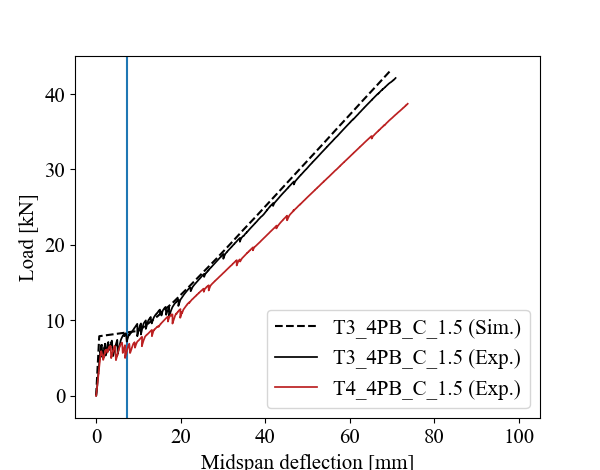

In [21]:
fig, ax = plot_fw(3, r'T3_4PB_C_1.5', dp=dp3_4, color_i=0)
plot_fw(4, r'T4_4PB_C_1.5', ax=ax, color_i=1)
# bu.get_fw_curves_avg([get_exp_fw(3, as_one_array=True), get_exp_fw(4, as_one_array=True)], ax=ax)
# fig.savefig('T3_T4_ld_exp_vs_sim.pdf')
fig.show()

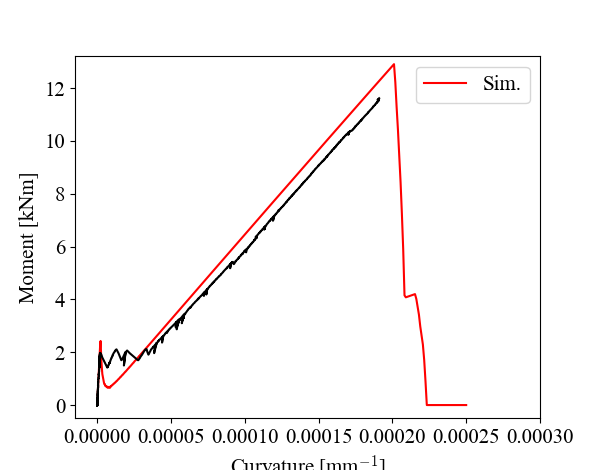

max_comp_strain = -0.0015994149999999999 , max_tensile_strain =  0.01463732


In [108]:
plot_mk(4, dp3_4, l_lvdt=250)

## T5_4PB_C_3

In [23]:
dp5 = get_dp(high_kappa =0.0003, B=201, H=80, setup='4pb', 
            reinf = 'carbon', 
            **M1_concrete,
            grid_layers_spacing=[10, 15, 20],
#              grid_layers_spacing=[8.9, 13.6, 19.4], # Real values from cut images
            grid_layers_area = [5 * 3.62, 5 * 3.62, 5 * 3.62]
            )

dp5.interact()

A= 65.16
rho = 0.46 %
l/d = 25.714285714285715
V_Rm_c = 9.88 kN, Shear failure by F_tot_max = 19.76 kN


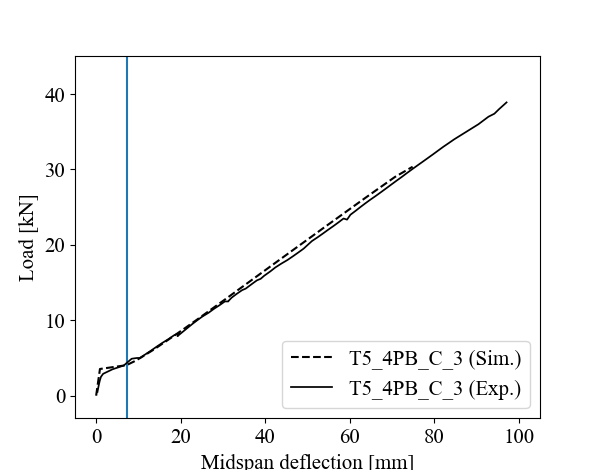

In [24]:
fig, ax = plot_fw(5, r'T5_4PB_C_3', dp=dp5, color_i=0)
fig.show()

## T6_4PB_C_3

In [25]:
dp6 = get_dp(high_kappa =0.0003, B=204, H=79, setup='4pb', 
            reinf = 'carbon',
            **M1_concrete,
           grid_layers_spacing=[10, 15, 20],
#              grid_layers_spacing=[8, 12.8, 19], # Real values from cut images
            grid_layers_area = [5 * 3.62, 5 * 3.62, 5 * 3.62]
            )
dp6.interact()

A= 65.16
rho = 0.46 %
l/d = 26.08695652173913
V_Rm_c = 9.81 kN, Shear failure by F_tot_max = 19.62 kN


In [26]:
plot_fw(6, r'T6_4PB_C_3', dp=dp6, ax=ax, color_i=1)
fig.show()

## T7_4PB_C_3

In [27]:
dp7 = get_dp(high_kappa =0.0003, B=204, H=81, setup='4pb', 
            reinf = 'carbon',
            **M2_concrete,
            grid_layers_spacing=[10, 15, 20],
            grid_layers_area = [5 * 3.62, 5 * 3.62, 5 * 3.62]
            )
# dp7.interact()

A= 65.16
rho = 0.45 %
l/d = 25.35211267605634


In [28]:
plot_fw(7, r'T7_4PB_C_3', dp=dp7, ax=ax, color_i=2)
# fig.savefig('T5_T6_T7_ld_exp_vs_sim.pdf')
fig.show()

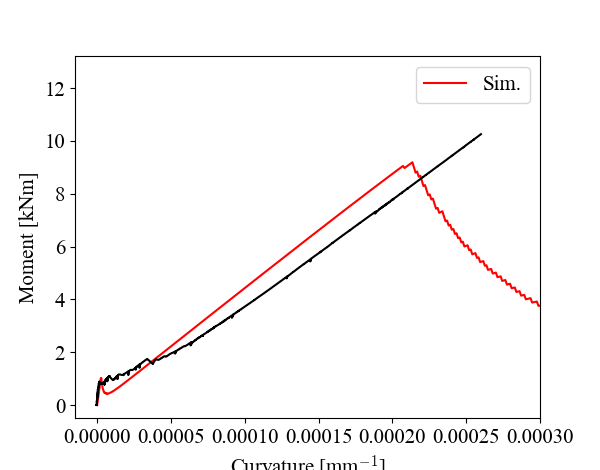

max_comp_strain = -0.0014353959999999998 , max_tensile_strain =  0.018064125


In [77]:
plot_mk(7, dp7)

### Additional functions

In [30]:
dp5 = get_dp(high_kappa =0.0003, B=201, H=80, setup='4pb', 
            reinf = 'carbon', 
            **M1_concrete,
            grid_layers_spacing=[15, 10, 20],
#              grid_layers_spacing=[8.9, 13.6, 19.4], # Real values from cut images
            grid_layers_area = [5 * 3.62, 5 * 3.62, 5 * 3.62]
            )

dp5.interact()

A= 65.16
rho = 0.46 %
l/d = 25.714285714285715
V_Rm_c = 9.05 kN, Shear failure by F_tot_max = 18.1 kN


In [31]:
# fig, axes = dp5.mc.plot_M_rho_and_util_factors(type='stress', n_rho = 20, reinf_layers_rho_factors=[0.33, 0.33, 0.34])
# # fig.savefig('hybrid_psi_ratios_factors_0.2_0.8.pdf')
# axes[0].axvline(x=0.42/100)
# axes[1].axvline(x=0.42/100)
# fig.show()

## T8_3PB_C_1

In [32]:
dp8 = get_dp(high_kappa =0.00023, B=300, H=100, setup='3pb', 
            reinf = 'carbon', 
            **M2_concrete,
            )
dp8.interact()

A= 28.96
rho = 0.11 %
l/d = 20.0


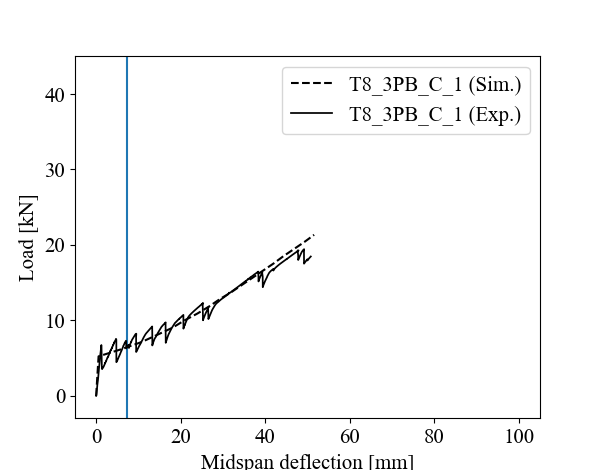

In [33]:
fig, ax = plot_fw(8, r'T8_3PB_C_1', dp=dp8, color_i=0)
fig.show()

## T9_3PB_C_1

In [34]:
dp9 = get_dp(high_kappa =0.00023, B=301, H=100, setup='3pb', 
            reinf = 'carbon', 
            **M2_concrete,
            )
dp9.interact()

A= 28.96
rho = 0.11 %
l/d = 20.0


In [35]:
plot_fw(9, r'T9_3PB_C_1', dp=dp9, ax=ax, color_i=1)
# fig.savefig('T8_T9_ld_exp_vs_sim.pdf')
fig.show()

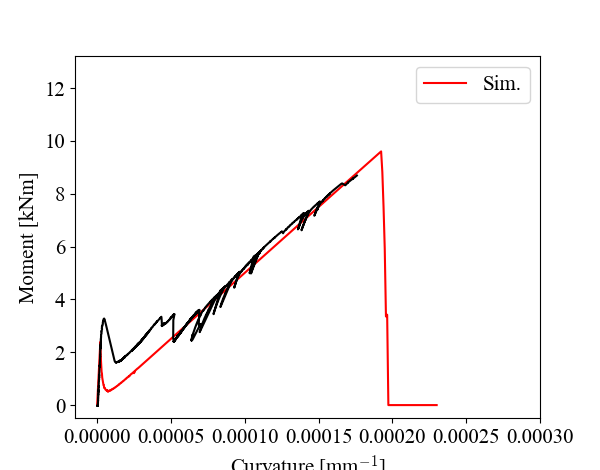

max_comp_strain = -0.002950702 , max_tensile_strain =  0.013764054999999999


In [80]:
plot_mk(9, dp9, gom=False)

## T10_4PB_CS_0.5

In [37]:
dp10 = get_dp(high_kappa =0.00025, B=303, H=100, setup='4pb', 
            reinf = 'carbon',
            A=4*3.62,
            z=20,
            **M2_concrete,
            )

steel_layer = ReinfLayer(name='steel', z=14, A=2*np.pi * (4**2), matmod='steel')
dp10.mc.cross_section_layout.add_layer(steel_layer)

dp10.interact()

A= 14.48
rho = 0.06 %
l/d = 22.5
V_Rm_c = 13.97 kN, Shear failure by F_tot_max = 27.94 kN


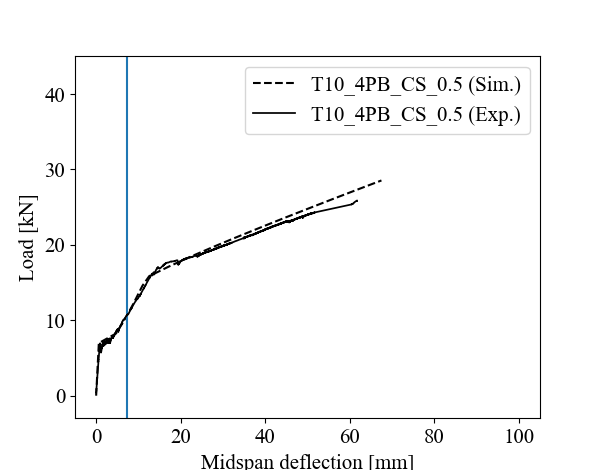

In [38]:
fig, ax = plot_fw(10, r'T10_4PB_CS_0.5', dp=dp10, color_i=0)
fig.show()

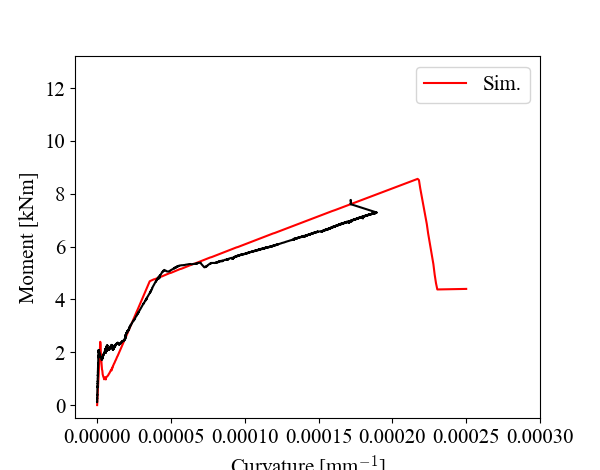

max_comp_strain = -0.0018939319999999999 , max_tensile_strain =  0.014431736


In [90]:
plot_mk(10, dp10, l_lvdt=250)

## T11_4PB_CS_0.5

In [40]:
dp11 = get_dp(high_kappa =0.00025, B=305, H=101, setup='4pb', 
            reinf = 'carbon',
            A=4*3.62,
            z=20,
            **M2_concrete,
            )

steel_layer = ReinfLayer(name='steel', z=14, A=2*np.pi * (4**2), matmod='steel')
dp11.mc.cross_section_layout.add_layer(steel_layer)

dp11.interact()

A= 14.48
rho = 0.06 %
l/d = 22.22222222222222
V_Rm_c = 14.24 kN, Shear failure by F_tot_max = 28.48 kN


In [41]:
plot_fw(11, r'T11_4PB_CS_0.5', dp=dp11, ax=ax, color_i=1)
# fig.savefig('T10_T11_ld_exp_vs_sim.pdf')
fig.show()

## T12_4PB_S, T13_4PB_S
Note: Combined because using the exact cross-section dimensions didn't give any noticeable difference in the behaviour

In [42]:
dp12_13 = get_dp(high_kappa =0.00062, B=300, H=100, setup='4pb', 
            reinf = 'steel', 
            A=4 * np.pi * (4**2), 
            z=14,
            **M2_concrete,
            )

# B500 reinf:
list(dp12_13.mc.cross_section_layout.items.values())[0].matmod_.eps_ud = 0.05
list(dp12_13.mc.cross_section_layout.items.values())[0].matmod_.f_sy = 550
list(dp12_13.mc.cross_section_layout.items.values())[0].matmod_.f_st = 578

dp12_13.interact()

A= 201.06192982974676
rho = 0.78 %
l/d = 20.930232558139537


C:\Users\hspartali\AppData\Local\Temp\ipykernel_16344\3028850393.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6, 4.7))


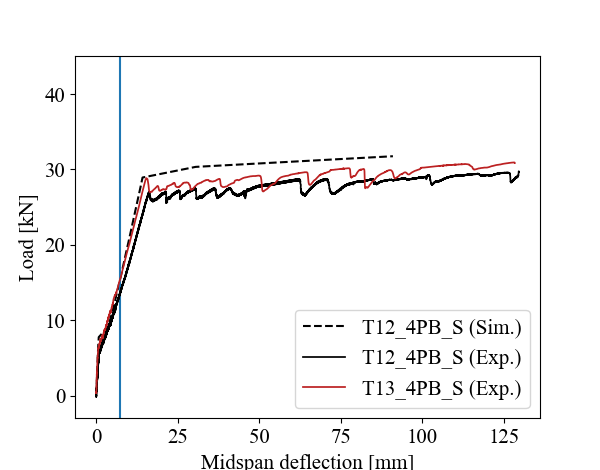

In [43]:
fig, ax = plot_fw(12, r'T12_4PB_S', dp=dp12_13, color_i=0)
plot_fw(13, r'T13_4PB_S', ax=ax, color_i=1)

# exp_fw_avg = bu.get_fw_curves_avg([get_exp_fw(12, as_one_array=True), get_exp_fw(13, as_one_array=True)], ax=ax)
# f_upper_env_ids = bu.get_asc_upper_env_ids(exp_fw_avg[0])
# ax.plot(exp_fw_avg[1][f_upper_env_ids], exp_fw_avg[0][f_upper_env_ids], 'g', label='high')

fig.show()

In [44]:
# fig.savefig('T12_T13_ld_exp_vs_sim.pdf')

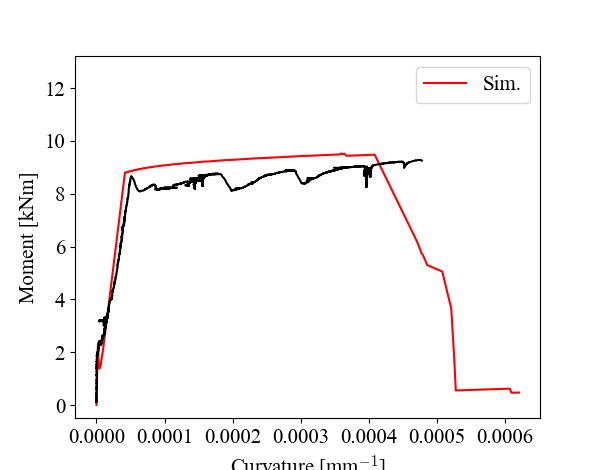

max_comp_strain = -0.003817206 , max_tensile_strain =  0.041200904999999996


In [45]:
plot_mk(13, dp12_13)

# Post-processing

In [115]:
dps = [dp1_2, dp1_2, dp3_4, dp3_4, dp5, dp6, dp7, dp8, dp9, dp10, dp11, dp12_13, dp12_13]

# Plotting MK curves vs tests

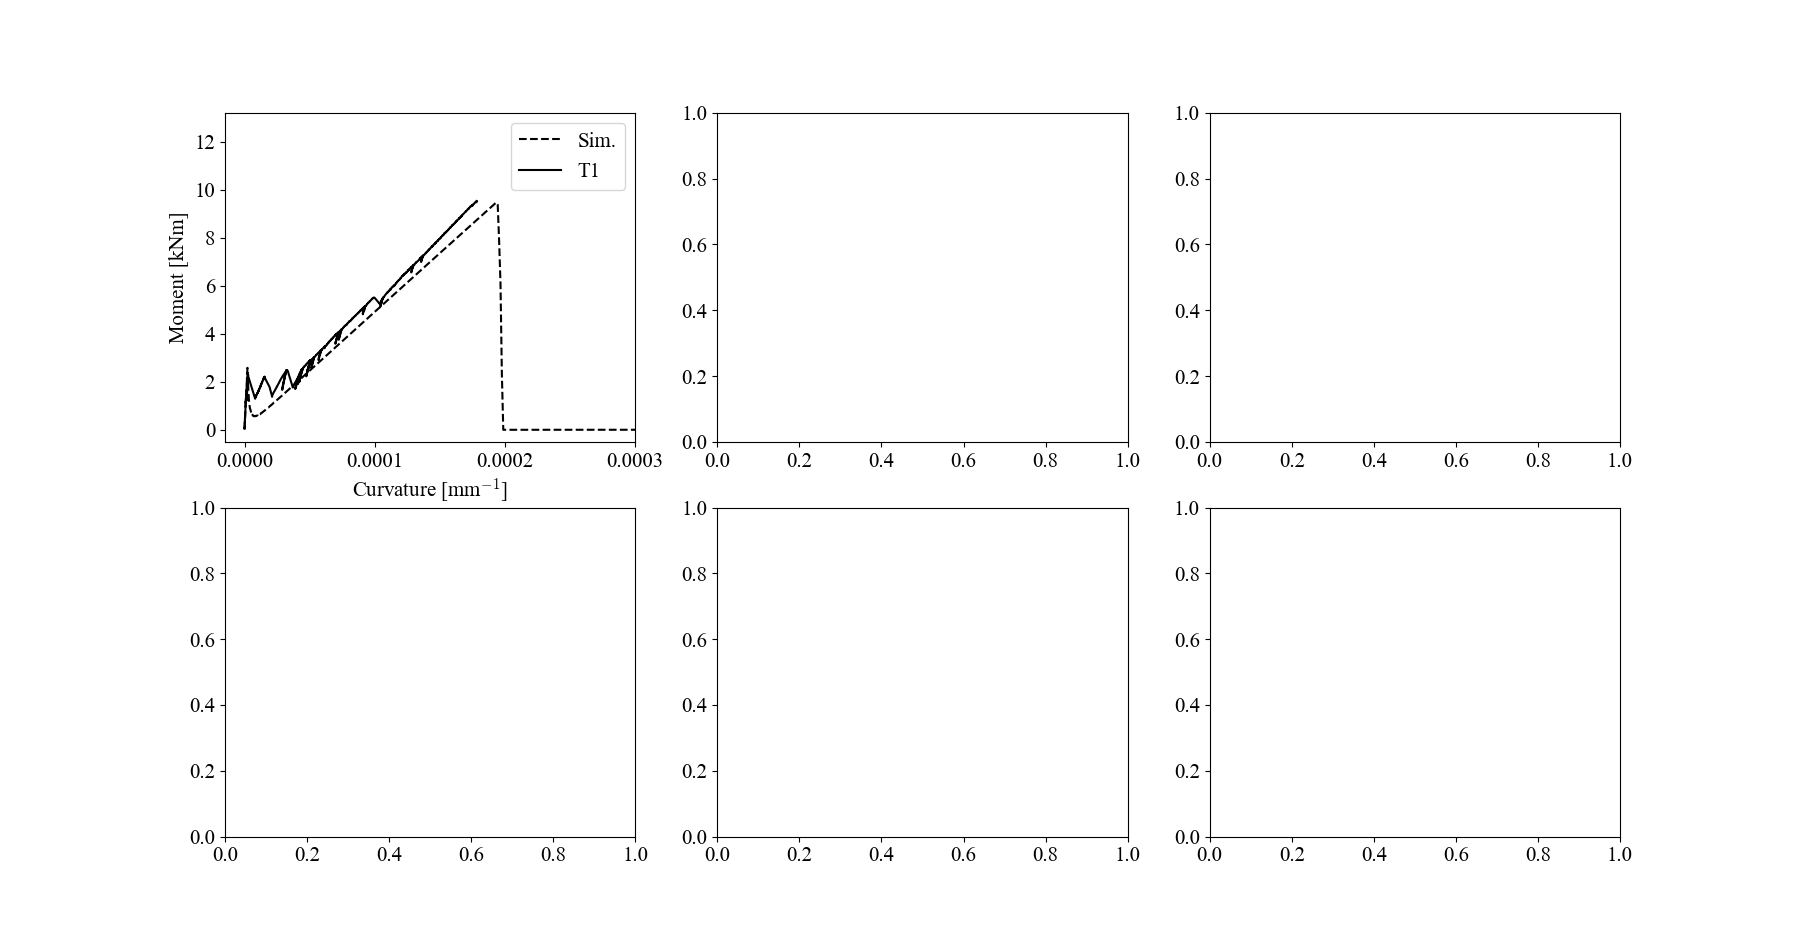

max_comp_strain = -0.0013027409999999998 , max_tensile_strain =  0.013847784
max_comp_strain = -0.0015994149999999999 , max_tensile_strain =  0.01463732
max_comp_strain = -0.0014353959999999998 , max_tensile_strain =  0.0144513
max_comp_strain = -0.002950702 , max_tensile_strain =  0.011011244
max_comp_strain = -0.0018939319999999999 , max_tensile_strain =  0.014431736
max_comp_strain = -0.003817206 , max_tensile_strain =  0.032960724


In [154]:
# fig, axes = plt.subplots(2, 3, figsize=(1.7*6, 1.6*4.7))
fig, axes = plt.subplots(1, 3, figsize=(3*6, 2*4.7))

tests = [1, 4, 7, 9, 10, 13]
plot_row = 0
for i, test_num in enumerate(tests):
    plot_mk(test_num, 
            dps[test_num - 1], 
            l_lvdt=250, 
            gom=False, 
            ax=axes[0 if i < 3 else 1, i if i < 3 else i - 3], 
            color_1='black',
           color_2='black')

fig.show()
fig.savefig('T' + str(tests)[1:-1].replace(', ', '_') + '_mk_curve_tests_vs_model.pdf')

# Exporting results summary

In [53]:
dps = [dp1_2, dp1_2, dp3_4, dp3_4, dp5, dp6, dp7, dp8, dp9, dp10, dp11, dp12_13, dp12_13]
df = None
for i, dp in enumerate(dps):
    df = get_limit_values(dp, i + 1, df=df)
df

,f_max_exp,f_max_sim,f_max_aci,w_max_exp,w_max_sim,f_sls_exp,f_sls_to_max,M_crack_exp,M_crack_aci,w_sls,w_sls_sim,w_sls_aci
,[kN],[kN],[kN],[mm],[mm],[kN],[-],[kNm],[kNm],[mm],[mm],[mm]
0,31.75,31.56,31.12,64.7,66.5,8.29,0.26,2.2,2.5,7.2,6.1,0.8
1,27.80,31.56,31.12,68.5,66.5,7.63,0.27,1.9,2.5,7.2,0.7,0.7
2,42.13,43.02,44.41,70.8,69.5,8.28,0.20,2.0,2.5,7.2,5.8,1.0
3,38.72,43.02,44.41,73.7,69.5,7.04,0.18,1.8,2.5,7.2,0.7,0.7
4,38.90,30.37,30.31,97.1,74.9,4.32,0.11,0.9,1.1,7.2,8.2,3.2
5,32.92,29.87,29.83,103.4,76.0,3.08,0.09,0.7,1.1,7.2,0.8,0.8
6,34.19,30.64,30.70,92.6,73.4,4.06,0.12,0.9,1.1,7.2,7.7,2.0
7,19.43,21.33,20.98,50.8,51.6,7.53,0.39,3.0,2.5,7.2,12.3,7.0
8,19.31,21.34,20.98,48.1,51.6,7.79,0.40,3.3,2.5,7.2,13.4,7.8


In [ ]:
print(df.to_latex())

# Comparing load-deflection curves of LVDTs and GOM

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(4*6, 4.7))

tests = [1, 6, 9, 12]
for i, test_num in enumerate(tests):
    plot_fw_gom(test_num, r'T' + str(test_num), ax=axes[i], color_i=0)
fig.show()
# fig.savefig('T' + str(tests)[1:-1].replace(', ', '_') + '_ld_curve_lvdts_vs_gom.pdf')